In [1]:
# %pip install pymorphy2
# %pip install nltk
# %pip install sklearn
# %pip install wordcloud
# %pip install stop_words

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from scipy.sparse import *
import stop_words
import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

import pickle

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
def display_conf_matrix(y_true, y_pred, Y):
    conf_matrix = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=Y.unique())
    cm_display.plot()
    plt.show()

In [6]:
def print_grid_search_info(model):
    print(f'Best estimator -> {model.best_estimator_}\n\
Best Score -> {model.best_score_}\n\
Best Parameters -> {model.best_params_}\n\
Best index -> {model.best_index_}')

In [7]:
def get_gridsearch_for_model(model, parameters : dict) -> GridSearchCV:
    model_grid = GridSearchCV(
        estimator=model,
        param_grid=parameters,
        scoring=['f1_micro', 'accuracy', 'recall_macro'],
        refit='f1_micro',
        cv=3,
        verbose=3,
        error_score=0
    )
    return model_grid

In [8]:
def save_model(path:str, model):
    with open(path, mode='wb') as pickle_file:
        pickle.dump(model, pickle_file)

def load_model(path:str):
    with open('./models/lin_svc.pkl', mode='rb') as pickle_file:
        model = pickle.load(pickle_file)
    return model

In [9]:
def print_metrics(y_test, y_pred):
    print(f'f1_micro = {f1_score(y_test, y_pred, average="micro")}\nrecall_score = {recall_score(y_test, y_pred, average="macro")}\nprecision_score = {precision_score(y_test, y_pred, average="macro")}')
    

# Data preprocessing

In [10]:
test_dataset = pd.read_csv("data/test.csv")
train_dataset = pd.read_csv("data/train.csv")
train_dataset.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Let's prepare copies of train dataset with 3 different text cleaning techniques (one method at a time):  
- stop words removing
- trash removing
- digits removing

In [11]:
train_dataset_splitted_texts = [line.split('\n') for line in train_dataset['Description']]
pd.DataFrame(train_dataset_splitted_texts)

,0
0,"Reuters - Short-sellers, Wall Street's dwindli..."
1,Reuters - Private investment firm Carlyle Grou...
2,Reuters - Soaring crude prices plus worries\ab...
3,Reuters - Authorities have halted oil export\f...
4,"AFP - Tearaway world oil prices, toppling reco..."
...,...
119995,KARACHI (Reuters) - Pakistani President Perve...
119996,Red Sox general manager Theo Epstein acknowled...
119997,The Miami Dolphins will put their courtship of...
119998,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [12]:
train_removed_stopwords = [' '.join([word if word not in stop_words.get_stop_words('en') else '' for word in text]) for text in train_dataset_splitted_texts]
pd.DataFrame(train_removed_stopwords)

,0
0,"Reuters - Short-sellers, Wall Street's dwindli..."
1,Reuters - Private investment firm Carlyle Grou...
2,Reuters - Soaring crude prices plus worries\ab...
3,Reuters - Authorities have halted oil export\f...
4,"AFP - Tearaway world oil prices, toppling reco..."
...,...
119995,KARACHI (Reuters) - Pakistani President Perve...
119996,Red Sox general manager Theo Epstein acknowled...
119997,The Miami Dolphins will put their courtship of...
119998,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [13]:
train_removed_punctuation = [' '.join([(' '.join(text)).translate(str.maketrans('', '', str("!\"\'(),-./:;?\\`")))]) for text in train_dataset_splitted_texts]
pd.DataFrame(train_removed_punctuation)
# train_removed_punctuation

,0
0,Reuters Shortsellers Wall Streets dwindlingba...
1,Reuters Private investment firm Carlyle Group...
2,Reuters Soaring crude prices plus worriesabou...
3,Reuters Authorities have halted oil exportflo...
4,AFP Tearaway world oil prices toppling record...
...,...
119995,KARACHI Reuters Pakistani President Pervez M...
119996,Red Sox general manager Theo Epstein acknowled...
119997,The Miami Dolphins will put their courtship of...
119998,PITTSBURGH at NY GIANTS Time 130 pm Line Steel...


In [14]:
exclude_symbols = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                            '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                            '\x7f', '\xad', '¤', '\xa0', '\u200b', '–']) + string.punctuation
regex_symb = re.compile('[%s]' % re.escape(exclude_symbols))

In [15]:
train_removed_trash = [regex_symb.sub('', ' '.join(text)) for text in train_dataset_splitted_texts]
train_removed_trash = [re.sub(r' +', ' ', text) for text in train_removed_trash]
pd.DataFrame(train_removed_trash)

,0
0,Reuters Shortsellers Wall Streets dwindlingban...
1,Reuters Private investment firm Carlyle Groupw...
2,Reuters Soaring crude prices plus worriesabout...
3,Reuters Authorities have halted oil exportflow...
4,AFP Tearaway world oil prices toppling records...
...,...
119995,KARACHI Reuters Pakistani President Pervez Mu...
119996,Red Sox general manager Theo Epstein acknowled...
119997,The Miami Dolphins will put their courtship of...
119998,PITTSBURGH at NY GIANTS Time 130 pm Line Steel...


In [16]:
regex_digit = re.compile('[%s]' % re.escape(string.digits))
train_removed_digits = [regex_digit.sub('', ' '.join(text)) for text in train_dataset_splitted_texts]
pd.DataFrame(train_removed_digits)

,0
0,"Reuters - Short-sellers, Wall Street's dwindli..."
1,Reuters - Private investment firm Carlyle Grou...
2,Reuters - Soaring crude prices plus worries\ab...
3,Reuters - Authorities have halted oil export\f...
4,"AFP - Tearaway world oil prices, toppling reco..."
...,...
119995,KARACHI (Reuters) - Pakistani President Perve...
119996,Red Sox general manager Theo Epstein acknowled...
119997,The Miami Dolphins will put their courtship of...
119998,PITTSBURGH at NY GIANTS Time: : p.m. Line: Ste...


## CountVectorizer

In [17]:
vectorizer = CountVectorizer(stop_words=stop_words.get_stop_words('en'), max_features=10000)

In [19]:
Y = train_dataset["Class Index"]
seed = 42

In [13]:
CVect_stopwords = vectorizer.fit_transform(train_removed_stopwords).toarray()

/home/habkaffee/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(CVect_stopwords, Y, test_size=0.25, random_state=seed)

In [ ]:
# parameters_logreg = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.01, 0.1, 0.5, 1.0, 10.0],
#     'solver': ['lbfgs', 'liblinear'],
#     'max_iter': [100, 500]
# }

# grid_log = get_gridsearch_for_model(LogisticRegression(), parameters_logreg)

# grid_log.fit(X_train, Y_train)
# print_grid_search_info(grid_log)

In [20]:
# Y_pred_logreg = grid_log.predict(X_test)
# print_metrics(Y_test, Y_pred_logreg)
# save_model('./models/log_reg.pkl', grid_log)

accuracy_score = 0.9016666666666667
recall_score = 0.9014730717851448
precision_score = 0.9013132593705164


In [ ]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 5),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [22]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/lin_svc.pkl', grid_linearSVC)

accuracy_score = 0.9051999999999999
recall_score = 0.9050006500418074
precision_score = 0.9049231276210165


In [ ]:
# MARK: Model is saved in KNN.pkl. Code commented to avoid exsistential crysis due to 5 hours of wasted time :D

# parameters_KNN = {
#     'n_neighbors' : [5, 6, 7],
#     'weights' : ['uniform', 'distance'],
#     'leaf_size' : [1, 2, 3],
#     'n_jobs' : [10]
# }

# grid_KNN = get_gridsearch_for_model(KNeighborsClassifier(), parameters_KNN)

# grid_KNN.fit(X_train, Y_train)
# print_grid_search_info(grid_KNN)

In [25]:
# Y_pred_KNN = grid_KNN.predict(X_test)
# print_metrics(Y_test, Y_pred_KNN)
# save_model('./models/KNN.pkl', grid_RFC)

accuracy_score = 0.5876333333333333
recall_score = 0.5868685205825099
precision_score = 0.6719880795980494


In [ ]:
CVect_trash = vectorizer.fit_transform(train_removed_trash).toarray()

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(CVect_trash, Y, test_size=0.25, random_state=seed)

In [ ]:
# parameters_logreg = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.01, 0.1, 0.5, 1.0, 10.0],
#     'solver': ['lbfgs', 'liblinear'],
#     'max_iter': [100, 500]
# }

# grid_log = get_gridsearch_for_model(LogisticRegression(), parameters_logreg)

# grid_log.fit(X_train, Y_train)
# print_grid_search_info(grid_log)

In [21]:
# Y_pred_logreg = grid_log.predict(X_test)
# print_metrics(Y_test, Y_pred_logreg)
# save_model('./models/log_reg_trash.pkl', grid_log)

accuracy_score = 0.8989
recall_score = 0.8987174214816545
precision_score = 0.8985895429774059


In [ ]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 5),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [ ]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/lin_svc_trash.pkl', grid_linearSVC)

In [19]:
CVect_digits = vectorizer.fit_transform(train_removed_digits).toarray()

/home/habkaffee/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(CVect_digits, Y, test_size=0.25, random_state=seed)

In [ ]:
# parameters_logreg = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.01, 0.1, 0.5, 1.0, 10.0],
#     'solver': ['lbfgs', 'liblinear'],
#     'max_iter': [100, 500]
# }

# grid_log = get_gridsearch_for_model(LogisticRegression(), parameters_logreg)

# grid_log.fit(X_train, Y_train)
# print_grid_search_info(grid_log)

In [22]:
# Y_pred_logreg = grid_log.predict(X_test)
# print_metrics(Y_test, Y_pred_logreg)
# save_model('./models/log_reg_digits.pkl', grid_log)

f1_micro = 0.9018333333333334
recall_score = 0.9016440165316573
precision_score = 0.9014961075002719


In [ ]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 5),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [24]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/lin_svc_digits.pkl', grid_linearSVC)

f1_micro = 0.9048
recall_score = 0.9046027739688296
precision_score = 0.9045058874334311


## TF-IDF

In [19]:
vectorizer = TfidfVectorizer(stop_words=stop_words.get_stop_words("en"), max_features=10000)

In [20]:
Y = train_dataset["Class Index"]
seed = 42

In [21]:
TF_IDF_stopwords = vectorizer.fit_transform(train_removed_stopwords).toarray()

/home/habkaffee/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(TF_IDF_stopwords, Y, test_size=0.25, random_state=seed)

In [ ]:
# MARK: Train took 2 hours. Tooooooo long. LinearSVC takes about 10 mins for same/better results. ¬_¬

# parameters_logreg = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.01, 0.1, 0.5, 1.0, 10.0],
#     'solver': ['lbfgs', 'liblinear'],
#     'max_iter': [100, 500]
# }

# grid_log = get_gridsearch_for_model(LogisticRegression(), parameters_logreg)

# grid_log.fit(X_train, Y_train)
# print_grid_search_info(grid_log)

In [24]:
# Y_pred_logreg = grid_log.predict(X_test)
# print_metrics(Y_test, Y_pred_logreg)
# save_model('./models/tfidf_log_reg.pkl', grid_log)

f1_micro = 0.9031333333333333
recall_score = 0.9029454615604425
precision_score = 0.9027714533817023


In [ ]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 5),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [26]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/tfidf_lin_svc.pkl', grid_linearSVC)

f1_micro = 0.9057
recall_score = 0.9054968328127582
precision_score = 0.9053354655929421


In [27]:
TF_IDF_trash = vectorizer.fit_transform(train_removed_trash).toarray()

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(TF_IDF_trash, Y, test_size=0.25, random_state=seed)

In [ ]:
# parameters_logreg = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.01, 0.1, 0.5, 1.0, 10.0],
#     'solver': ['lbfgs', 'liblinear'],
#     'max_iter': [100, 500]
# }

# grid_log = get_gridsearch_for_model(LogisticRegression(), parameters_logreg)

# grid_log.fit(X_train, Y_train)
# print_grid_search_info(grid_log)

In [ ]:
# Y_pred_logreg = grid_log.predict(X_test)
# print_metrics(Y_test, Y_pred_logreg)
# save_model('./models/tfidf_log_reg_trash.pkl', grid_log)

In [ ]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 5),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [30]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/tfidf_lin_svc_trash.pkl', grid_linearSVC)

f1_micro = 0.9035333333333334
recall_score = 0.9033344208409184
precision_score = 0.903135971056928


In [31]:
TF_IDF_digits = vectorizer.fit_transform(train_removed_digits).toarray()

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(TF_IDF_digits, Y, test_size=0.25, random_state=seed)

In [ ]:
# parameters_logreg = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.01, 0.1, 0.5, 1.0, 10.0],
#     'solver': ['lbfgs', 'liblinear'],
#     'max_iter': [100, 500]
# }

# grid_log = get_gridsearch_for_model(LogisticRegression(), parameters_logreg)

# grid_log.fit(X_train, Y_train)
# print_grid_search_info(grid_log)

In [ ]:
# Y_pred_logreg = grid_log.predict(X_test)
# print_metrics(Y_test, Y_pred_logreg)
# save_model('./models/tfidf_log_reg_digits.pkl', grid_log)

In [ ]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 5),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [34]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/tfidf_lin_svc_digits.pkl', grid_linearSVC)

f1_micro = 0.9052666666666667
recall_score = 0.9050644250852479
precision_score = 0.9048826648675069


## Lemmatization and try over

In [17]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [18]:
train_removed_stopwords_copy = [' '.join([lemmatizer.lemmatize(word, pos="n") for word in text.split()]) for text in train_removed_stopwords]
train_removed_stopwords_copy = [' '.join([lemmatizer.lemmatize(word, pos="a") for word in text.split()]) for text in train_removed_stopwords]
train_removed_stopwords_copy = [' '.join([lemmatizer.lemmatize(word, pos="v") for word in text.split()]) for text in train_removed_stopwords]
train_removed_stopwords_copy = [' '.join([lemmatizer.lemmatize(word, pos="r") for word in text.split()]) for text in train_removed_stopwords]
train_removed_stopwords_copy = [' '.join([lemmatizer.lemmatize(word, pos="s") for word in text.split()]) for text in train_removed_stopwords]

train_removed_trash_copy = [' '.join([lemmatizer.lemmatize(word, pos="n") for word in text.split()]) for text in train_removed_trash]
train_removed_trash_copy = [' '.join([lemmatizer.lemmatize(word, pos="a") for word in text.split()]) for text in train_removed_trash]
train_removed_trash_copy = [' '.join([lemmatizer.lemmatize(word, pos="v") for word in text.split()]) for text in train_removed_trash]
train_removed_trash_copy = [' '.join([lemmatizer.lemmatize(word, pos="r") for word in text.split()]) for text in train_removed_trash]
train_removed_trash_copy = [' '.join([lemmatizer.lemmatize(word, pos="s") for word in text.split()]) for text in train_removed_trash]

train_removed_digits_copy = [' '.join([lemmatizer.lemmatize(word, pos="n") for word in text.split()]) for text in train_removed_digits]
train_removed_digits_copy = [' '.join([lemmatizer.lemmatize(word, pos="a") for word in text.split()]) for text in train_removed_digits]
train_removed_digits_copy = [' '.join([lemmatizer.lemmatize(word, pos="v") for word in text.split()]) for text in train_removed_digits]
train_removed_digits_copy = [' '.join([lemmatizer.lemmatize(word, pos="r") for word in text.split()]) for text in train_removed_digits]
train_removed_digits_copy = [' '.join([lemmatizer.lemmatize(word, pos="s") for word in text.split()]) for text in train_removed_digits]

In [19]:
vectorizer = CountVectorizer(stop_words=stop_words.get_stop_words('en'), max_features=10000)

In [20]:
Y = train_dataset["Class Index"]
seed = 42

In [21]:
CVect_stopwords = vectorizer.fit_transform(train_removed_stopwords_copy).toarray()

/home/habkaffee/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(CVect_stopwords, Y, test_size=0.25, random_state=seed)

In [23]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 5),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [25]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/lemmat_lin_svc.pkl', grid_linearSVC)

f1_micro = 0.9045333333333333
recall_score = 0.9043353591136335
precision_score = 0.9042743026896476


In [26]:
CVect_trash = vectorizer.fit_transform(train_removed_trash_copy).toarray()

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(CVect_trash, Y, test_size=0.25, random_state=seed)

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [29]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/lemmat_lin_svc_trash.pkl', grid_linearSVC)

f1_micro = 0.9031333333333333
recall_score = 0.9029243615170612
precision_score = 0.9027782087428682


In [30]:
CVect_digits = vectorizer.fit_transform(train_removed_digits_copy).toarray()

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(CVect_digits, Y, test_size=0.25, random_state=seed)

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [33]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/lemmat_lin_svc_digits.pkl', grid_linearSVC)

f1_micro = 0.9043666666666667
recall_score = 0.9041685957174672
precision_score = 0.9040971142191401


In [34]:
vectorizer = TfidfVectorizer(stop_words=stop_words.get_stop_words("en"), max_features=10000)

In [35]:
Y = train_dataset["Class Index"]
seed = 42

In [36]:
TF_IDF_stopwords = vectorizer.fit_transform(train_removed_stopwords_copy).toarray()

/home/habkaffee/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [37]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 5),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(TF_IDF_stopwords, Y, test_size=0.25, random_state=seed)

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [40]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/lemmat_tfidf_lin_svc.pkl', grid_linearSVC)

f1_micro = 0.9052333333333333
recall_score = 0.9050308774115083
precision_score = 0.9048689336645132


In [41]:
TF_IDF_trash = vectorizer.fit_transform(train_removed_trash_copy).toarray()

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(TF_IDF_trash, Y, test_size=0.25, random_state=seed)

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [44]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/lemmat_tfidf_lin_svc_trash.pkl', grid_linearSVC)

f1_micro = 0.9032333333333333
recall_score = 0.9030318371101944
precision_score = 0.9028357412750577


In [45]:
TF_IDF_digits = vectorizer.fit_transform(train_removed_digits_copy).toarray()

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(TF_IDF_digits, Y, test_size=0.25, random_state=seed)

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [48]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/lemmat_tfidf_lin_svc_digits.pkl', grid_linearSVC)

f1_micro = 0.9051
recall_score = 0.904896421008043
precision_score = 0.9047320676323019


## Stemming

In [17]:
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [19]:
train_removed_stopwords = [' '.join([stemmer.stem(word) for word in text.split()]) for text in train_removed_stopwords]

train_removed_trash = [' '.join([stemmer.stem(word) for word in text.split()]) for text in train_removed_trash]

train_removed_digits = [' '.join([stemmer.stem(word) for word in text.split()]) for text in train_removed_digits]


In [20]:
vectorizer = CountVectorizer(stop_words=stop_words.get_stop_words('en'), max_features=10000)

In [21]:
Y = train_dataset["Class Index"]
seed = 42

In [22]:
CVect_stopwords = vectorizer.fit_transform(train_removed_stopwords).toarray()

/home/habkaffee/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(CVect_stopwords, Y, test_size=0.25, random_state=seed)

In [24]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 5),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [26]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/lemmat_lin_svc.pkl', grid_linearSVC)

f1_micro = 0.9054333333333333
recall_score = 0.9052204725721449
precision_score = 0.9051306886529678


In [27]:
CVect_trash = vectorizer.fit_transform(train_removed_trash).toarray()

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(CVect_trash, Y, test_size=0.25, random_state=seed)

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [30]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/stem_lin_svc_trash.pkl', grid_linearSVC)

f1_micro = 0.9031333333333333
recall_score = 0.9029339955089166
precision_score = 0.9028637161310636


In [31]:
CVect_digits = vectorizer.fit_transform(train_removed_digits).toarray()

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(CVect_digits, Y, test_size=0.25, random_state=seed)

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [34]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/stem_lin_svc_digits.pkl', grid_linearSVC)

f1_micro = 0.9051666666666667
recall_score = 0.9049585600507555
precision_score = 0.9048495186429608


In [35]:
vectorizer = TfidfVectorizer(stop_words=stop_words.get_stop_words("en"), max_features=10000)

In [36]:
Y = train_dataset["Class Index"]
seed = 42

In [37]:
TF_IDF_stopwords = vectorizer.fit_transform(train_removed_stopwords).toarray()

/home/habkaffee/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [38]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 5),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(TF_IDF_stopwords, Y, test_size=0.25, random_state=seed)

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [41]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/stem_tfidf_lin_svc.pkl', grid_linearSVC)

f1_micro = 0.9047
recall_score = 0.9044897923303211
precision_score = 0.9042979141655177


In [42]:
TF_IDF_trash = vectorizer.fit_transform(train_removed_trash).toarray()

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(TF_IDF_trash, Y, test_size=0.25, random_state=seed)

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [45]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/stem_tfidf_lin_svc_trash.pkl', grid_linearSVC)

f1_micro = 0.9018333333333334
recall_score = 0.9016271360697213
precision_score = 0.9014087459406611


In [46]:
TF_IDF_digits = vectorizer.fit_transform(train_removed_digits).toarray()

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(TF_IDF_digits, Y, test_size=0.25, random_state=seed)

In [ ]:
grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

In [49]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)
save_model('./models/stem_tfidf_lin_svc_digits.pkl', grid_linearSVC)

f1_micro = 0.9052333333333333
recall_score = 0.9050254743336412
precision_score = 0.9048591958377651


# Comparison

In [17]:
seed = 42
# vectorizer = TfidfVectorizer(stop_words=stop_words.get_stop_words("en"), max_features=10000)
# TF_IDF_trash = vectorizer.fit_transform(train_removed_trash_copy).toarray()
vectorizer = CountVectorizer(stop_words=stop_words.get_stop_words('en'), max_features=10000)
# CVect_trash = vectorizer.fit_transform(train_removed_trash).toarray()

Y = train_dataset["Class Index"]
vectorized = vectorizer.fit_transform(train_removed_trash).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(vectorized, Y, test_size=0.25, random_state=seed)

# linSVC_best = load_model('./models/lemmat_tfidf_lin_svc_trash.pkl')
logreg = load_model('./models/log_reg_trash.pkl')

Y_pred_logreg = logreg.predict(X_test)

/home/habkaffee/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [18]:
def fill_metrix_df(metrix, name, f1_micro, recall, precision):
    metrix[name] = [f1_micro, recall, precision]

all_metrics_df = pd.DataFrame(index=['f1_micro', 'Recall', 'Precision'])

fill_metrix_df(all_metrics_df, 'LinearSVC',
                f1_score(Y_test, Y_pred_logreg, average='micro'), 
                recall_score(Y_test, Y_pred_logreg, average='macro'), 
                precision_score(Y_test, Y_pred_logreg, average='macro'))

LinearSVC

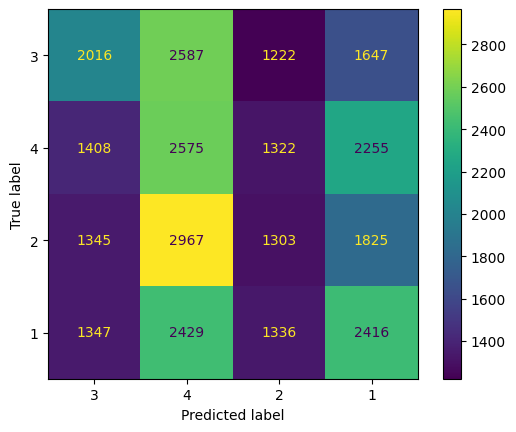

In [19]:
display_conf_matrix(Y_test, Y_pred_logreg, Y)

All metrics are displayed below

In [20]:
all_metrics_df

,LinearSVC
f1_micro,0.277000
Recall,0.276621
Precision,0.280403


In [20]:
data_to_submit = pd.read_csv('./data/test.csv')
test_dataset_splitted_texts = [line.split('\n') for line in data_to_submit['Description']]
data_to_submit = [' '.join([word if word not in stop_words.get_stop_words('en') else '' for word in text]) for text in test_dataset_splitted_texts]
vectorized_data = vectorizer.fit_transform(data_to_submit).toarray()

y_predicted = linSVC_best.predict(vectorized_data)
with open("submission.csv", 'w+') as f:
    f.write("ID, Class Index\n") 
    for i, el in enumerate(y_predicted):
        f.write(f'{i}, {el}\n')

pd.DataFrame(y_predicted)

,0
0,1
1,4
2,2
3,4
4,2
...,...
7595,4
7596,4
7597,4
7598,4


### Summary